In [1]:
%reset -f
import sys
import numpy as np
sys.path.insert(0, '..')
from wavhandler import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils_train import *
import deepdish as dd
import os
import glob
from natsort import natsorted
import matplotlib.pyplot as plt

!cd /home/kalfasyan/projects/wingbeat_frequencies/temp_data/from_cluster/

In [2]:
os.chdir('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/')
!pwd

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results


### Helper functions

In [3]:
def extract_dl_results(d, custom=False):
    idx_bst = d['val_loss'].index(min(d['val_loss']))
    train_score = d['train_score'][idx_bst]
    val_score = d['val_score'][idx_bst]
#     train_loss = d['train_loss'][idx_bst]
#     val_loss = d['val_loss'][idx_bst]
    balanced_acc_test = d['balanced_acc_test']
    logloss_test = d['logloss_test']
    if custom:
        return train_score,val_score,balanced_acc_test,logloss_test
    else:
        return f'{train_score:.2f}-{val_score:.2f}-{balanced_acc_test:.2f}, {logloss_test:.2f}'

def extract_ml_results(d, custom=False):
    train_score = d['train_score']
    val_score = d['val_score']
    balanced_acc_test = d['balanced_acc_test']
    logloss_test = d['logloss_test']
    if custom:
        print(f'{train_score:.2f}-{val_score:.2f}-{balanced_acc_test:.2f}, {logloss_test:.2f}')
        return train_score,val_score,balanced_acc_test,logloss_test
    else:
        return f'{train_score:.2f}-{val_score:.2f}-{balanced_acc_test:.2f}, {logloss_test:.2f}'

fnames_dl = natsorted(glob.glob('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/dl/**results.h5'))
#fnames_dl
fnames_ml = natsorted(glob.glob('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/**results.h5'))

# RESULTS TABLE

### DL results

In [4]:
for j, f in enumerate(fnames_dl):
    d = dd.io.load(f)['results']
    f = f.split('/')[-1][:-4]
    lk = list(d.keys())

    if len(lk) == 1:
        if lk[0] == 'random':
            print(f"{f}:\t\t {extract_dl_results(d['random'])}")
        elif lk[0] == 'randomcv':
            print(f"{f}:\t\t {extract_dl_results(d['randomcv'])}")
    elif len(lk) == 5:
        tmp = []
        for i in range(5):
            print(extract_dl_results(d[f'custom_{i}'], custom=True))
            tmp.append(extract_dl_results(d[f'custom_{i}'], custom=True))
        
        stacked = np.vstack(tmp)
        stacked = np.mean(stacked, axis=0)
        print(np.std([tmp[i][2] for i in range(len(tmp))]))
        print(f'{f}:\t\t {stacked[0]:.2f}-{stacked[1]:.2f}-{stacked[2]:.2f}, {stacked[3]:.2f}\n')


/home/kalfasyan/anaconda3/envs/wbtf2/lib/python3.6/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


(0.87094724, 0.7545, 0.5366666666666667, 1.8379499228243046)
(0.8801107, 0.83383334, 0.5398333333333333, 1.9157950916227777)
(0.85914713, 0.8211667, 0.5321666666666667, 2.069898148924888)
(0.8775879, 0.8599167, 0.5523333333333333, 1.8211196342744491)
(0.8917806, 0.78975, 0.53725, 2.181346241810939)
0.006805308385534204
custom_psd_dB_conv1d_result:		 0.88-0.81-0.54, 1.97

(0.8611491, 0.73941666, 0.5123333333333334, 2.0832492984952937)
(0.9000651, 0.84066665, 0.5476666666666666, 1.9215996512834268)
(0.88528645, 0.8275833, 0.5353333333333333, 1.9473660677915365)
(0.91069335, 0.86941665, 0.5583333333333333, 2.089141104106005)
(0.8876302, 0.7938333, 0.5475833333333333, 1.9735363488504087)
0.015743605403817452
custom_psd_dB_gru_result:		 0.89-0.81-0.54, 2.00

(0.97122395, 0.85541666, 0.68925, 1.4270669731676737)
(0.96054685, 0.909, 0.6824166666666667, 1.383564303334486)
(0.94889325, 0.91141665, 0.68825, 1.235955000882125)
(0.9489095, 0.9315, 0.6883333333333334, 1.3549969026830242)
(0.9516276

In [5]:
print([tmp[i][2] for i in range(len(tmp))])

[0.6276666666666667, 0.6454166666666666, 0.64475, 0.6406666666666667, 0.6234166666666666]


## ML results

In [6]:
for j, f in enumerate(fnames_ml):
    print(f)
    d = dd.io.load(f)['results']
    f = f.split('/')[-1][:-4]
    lk = list(d.keys())

    if len(lk) == 1:
        if lk[0] == 'random':
            print(f"{f}:\t\t {extract_ml_results(d['random'])}")
        elif lk[0] == 'randomcv':
            print(f"{f}:\t\t {extract_ml_results(d['randomcv'])}")
    elif len(lk) > 5:
        
        tmp = []
#         for i in range(5):
            #print(extract_ml_results(d, custom=True))
        print(f"train_score: {d['train_score']}")
        print(f"val_score: {d['val_score']}")
        print(f"b_accs: {np.std(d['b_accs'])}")
        print(f"logloss: {d['logloss']}")
        print()
# #         stacked = np.vstack(tmp)
# #         stacked = np.mean(stacked, axis=0)
#         print(f'{f}:\t\t {stacked[0]:.2f}-{stacked[1]:.2f}-{stacked[2]:.2f}, {stacked[3]:.2f}\n')
        
#         break

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/custom_psd_dB_knn_results.h5
train_score: 0.7860872395833334
val_score: 0.7170703125
b_accs: 0.007810142977777851
logloss: [8.710065746981995, 8.341781812973753, 8.847030246548137, 8.224602355678005, 8.302050273995246]

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/custom_psd_dB_randomforest_results.h5
train_score: 0.9664257812500001
val_score: 0.741953125
b_accs: 0.00990151503558924
logloss: [1.486562555003893, 1.4569648914868218, 1.461580932432323, 1.4072972211030144, 1.4419154076715273]

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/random_psd_dB_knn_results.h5
random_psd_dB_knn_result:		 0.78-0.73-0.73, 2.02
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/random_psd_dB_randomforest_results.h5
random_psd_dB_randomforest_result:		 0.97-0.77-0.76, 0.71
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/random_psd_dB_xgboost_results.h5
random_p

# CONFUSION MATRIX

In [7]:
path_results = '/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/'
path_dl = f'{path_results}dl/'
path_ml = f'{path_results}ml/'

def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

def result_confusion_mat(data_setting=None, model_setting=None, splitting=None, cus=0, plot=True):
    if splitting == 'custom':
        d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][f'custom_{cus}']
    elif splitting == 'random' or splitting == 'randomcv':
        d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][splitting]

    y_pred = np.argmax(d['y_pred'], axis=1)
    y_test = d['y_test']
    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    integerMapping = get_integer_mapping(le)
    mapping = {v: k for k, v in integerMapping.items()}
    y = [mapping[x] for x in y_test]

    if plot:
        plt.figure(figsize=(18,12))
        labels = pd.Series(y).unique().tolist()
        sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='.0f')
    return cm

In [8]:
splitting = 'random'
data = Dataset('Wingbeats')
X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting='custom', dataset=data, return_label_encoder=True)

Species: Ae. aegypti.
Read 85553 filenames in 1.85 seconds.
['20170209', '20161213', '20161212', '20170212', '20170208', '20170207', '20170206', '20170210', '20170211', '20170213']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.45 seconds.
['20170228', '20170103', '20170301', '20170227', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.44 seconds.
['20170203', '20170204', '20170318', '20170202', '20170130', '20170319', '20170201', '20170315', '20170316', '20170314', '20170205', '20170317', '20170131', '20170206', '20170313', '20170320']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.47 seconds.
['20170109', '20170110', '20170120', '20170121', '20170122', '20170117', '20170123', '20170116', '20170119', '20170118']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Read 74599 filenames in 1.43 seconds.
['20161220', '2016

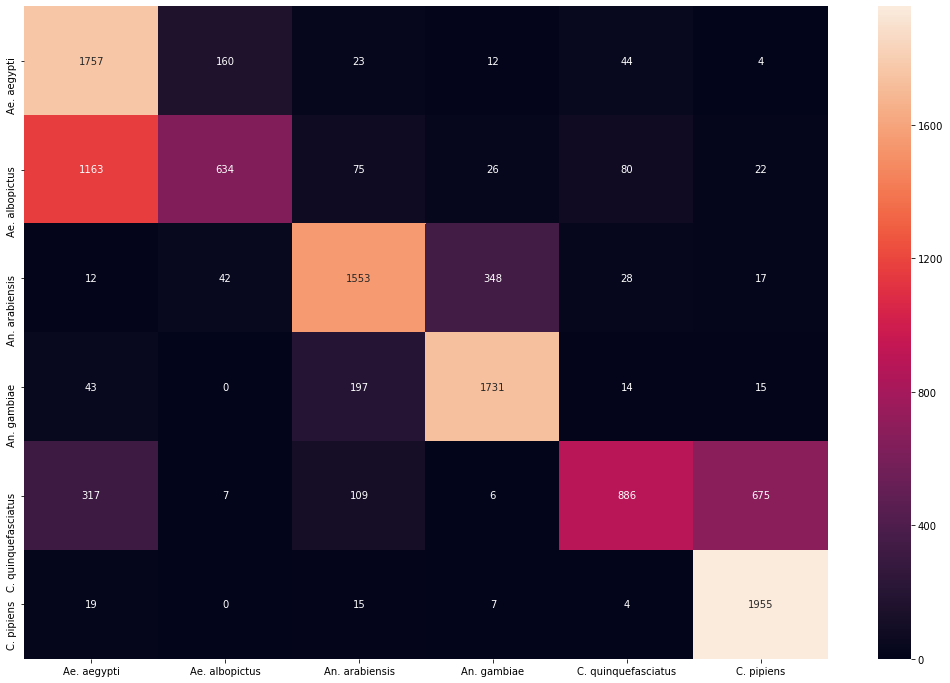

In [9]:
result_confusion_mat(data_setting = 'raw', model_setting = 'dl4tsc_inc', splitting='custom');

In [12]:
(1757+1163+634+160 + 1553+197+348+1731  + 886+675+4+1955)/12000 * 100

92.19166666666668

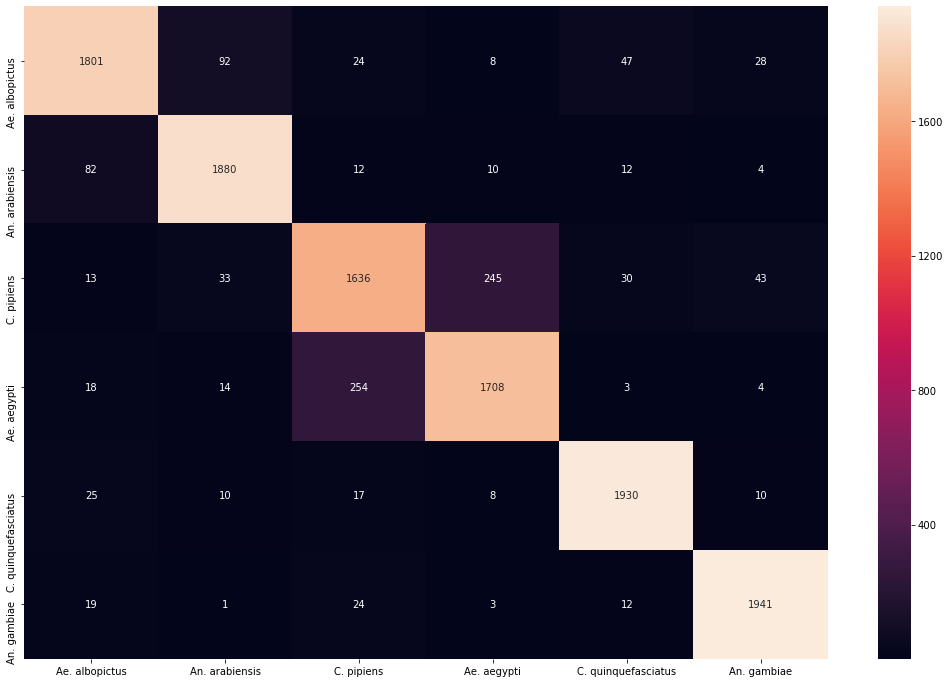

In [23]:
result_confusion_mat(data_setting = 'raw', model_setting = 'dl4tsc_inc', splitting='random');

## Average custom array

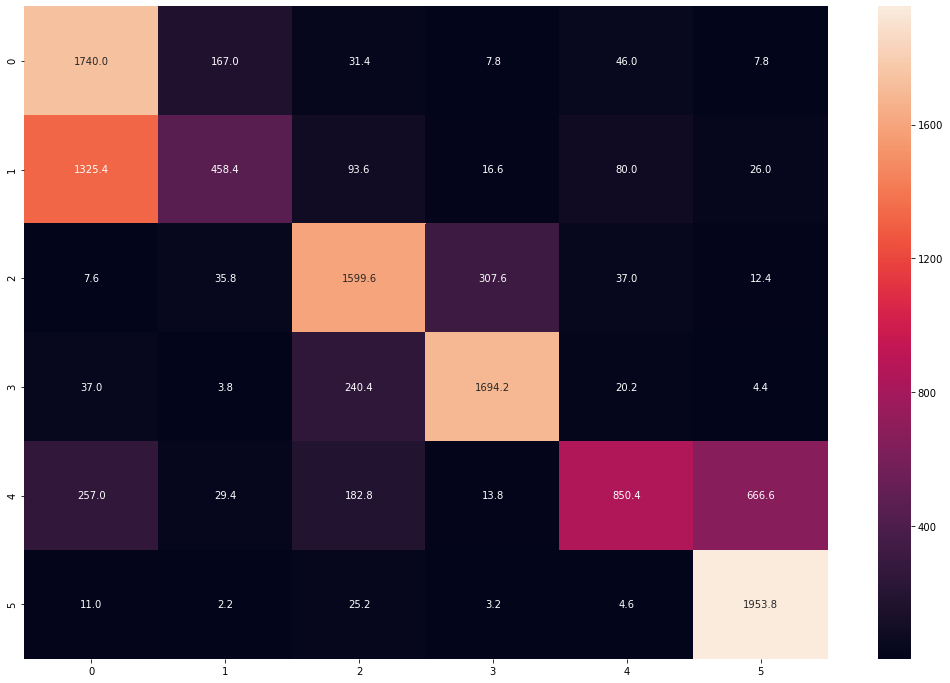

In [10]:
cms = []
for i in range(5):
    cms.append(result_confusion_mat(data_setting = 'raw', model_setting = 'dl4tsc_res', splitting='custom', cus=i, plot=False))
cmfinal = np.average(cms, axis=0)

plt.figure(figsize=(18,12))
sns.heatmap(cmfinal, annot=True, fmt='.01f')